# `PyNeuronToolbox` example usage

[**Alex Williams**](http://alexhwilliams.info)

This ipython notebook demonstrates how to use [PyNeuron Toolbox](https://github.com/ahwillia/PyNeuron-Toolbox/), along with the [NEURON](http://www.neuron.yale.edu/neuron/) python module, to visualize the propogation of an action potential down an axon and in a model with realistic morphology. NEURON allows you to make visualizations like this with "shape plots" (see this tutorial). This demo will show you how to use PyNeuron Toolbox to make similar plots directly in python.

#### First example: Hodgkin-Huxley model in a cable

We'll run a short simulation of a cable with Hodgkin-Huxley currents. The details for running NEURON simulations in python can be found in [Hines et al. (2009)](http://journal.frontiersin.org/Journal/10.3389/neuro.11.001.2009/abstract).

We will use two functions from PyNeuron Toolbox, `ez_record` and `ez_convert`, to quickly record the membrane potential in all compartments of our cell. Using these functions is completely optional to making shape plots. Briefly, `ez_record` records the membrane potential for all compartments, and `ez_convert` converts all the `h.Vector()` objects into numpy arrays. The result is a matrix v whose columns are the membrane potential traces for all compartments (the labels for each compartment are returned by `record_v` for reference). These functions can also be used to record other common state variables in Neuron, such as the intracellular calcium concentration.

#### Second example: Realistic CA1 morphology

We'll visualize changes in membrane potential across a neuron with realistic morophology [(Migliore et al., 2005)](http://senselab.med.yale.edu/ModelDB/ShowModel.cshtml?model=55035&file=/obliques/geo5038804.hoc). For simplicity we populate this model with the Hodgkin-Huxley sodium and potassium channel models. This is not realistic. But it illustrates the plotting capabilities of this toolbox.
In addition, the code shows how to use the function `mark_locations` from the morphology toolbox to indicate the location for our current injection.


### Simulate Hodgkin-Huxley model

In [7]:
from __future__ import division
from neuron import h
import numpy as np

# list plotting backends and choose suitable one
%matplotlib --list
%matplotlib notebook

# must import matplotlib AFTER setting backend
import matplotlib.pyplot as plt

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [13]:
# PyNeuronToolbox imports
from PyNeuronToolbox.record import ez_record, ez_convert

# create model
h.load_file('stdrun.hoc')
cell = h.Section()

cell.nseg = 11   # It is a good idea to have nseg be an odd number
cell.Ra = 35.4   # Ohm*cm

cell.insert('hh')

# create 3d structure
h.pt3dadd(0,0,0,1.0,sec=cell)
h.pt3dadd(1732,1732,1732,1.0,sec=cell)

# Specify current injection
stim = h.IClamp(1.0,sec=cell)
stim.delay = 1   # ms
stim.dur = 100   # ms
stim.amp = 0.2   # nA

# Segment positions, equall spaced from 0 to 1
seg_positions = np.linspace(0,1,cell.nseg)

# Use toolbox to record v
# ez_record records v in all compartments by default
(v,v_labels) = ez_record(h)

# Manually record time and current
t, I = h.Vector(), h.Vector()
t.record(h._ref_t)
I.record(stim._ref_i)

# Run the simulation 
h.init()
h.tstop = 25
h.run()

# Use toolbox convert v into a numpy 2D array
v = ez_convert(v) 

### Create a 3D plot showing the morphology

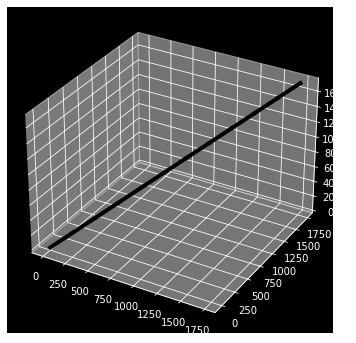

In [14]:
from PyNeuronToolbox.morphology import shapeplot
from mpl_toolkits.mplot3d import Axes3D

# Plot shapeplot
plt.figure(figsize=(6,6))
shapeax = plt.subplot(111, projection='3d')
shapeplot(h,shapeax,lw=4)
plt.show()

### 3D animation showing propagation of action potentials  down cable

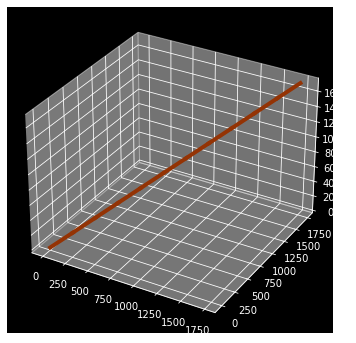

In [15]:
# Animation imports
from matplotlib import animation

# PyNeuronToolbox function for easy animation
from PyNeuronToolbox.morphology import shapeplot_animate

# Plot shapeplot (as above)
fig = plt.figure(figsize=(6,6))
shapeax = plt.subplot(111, projection='3d')
shapelines = shapeplot(h,shapeax,lw=4)

# Make the animation
nframes = 100
shape_animate = shapeplot_animate(v,shapelines,nframes)
animation.FuncAnimation(fig, shape_animate, frames=nframes, interval=40, blit=True)

### Fancier animation, showing voltage traces and 3D shapeplot

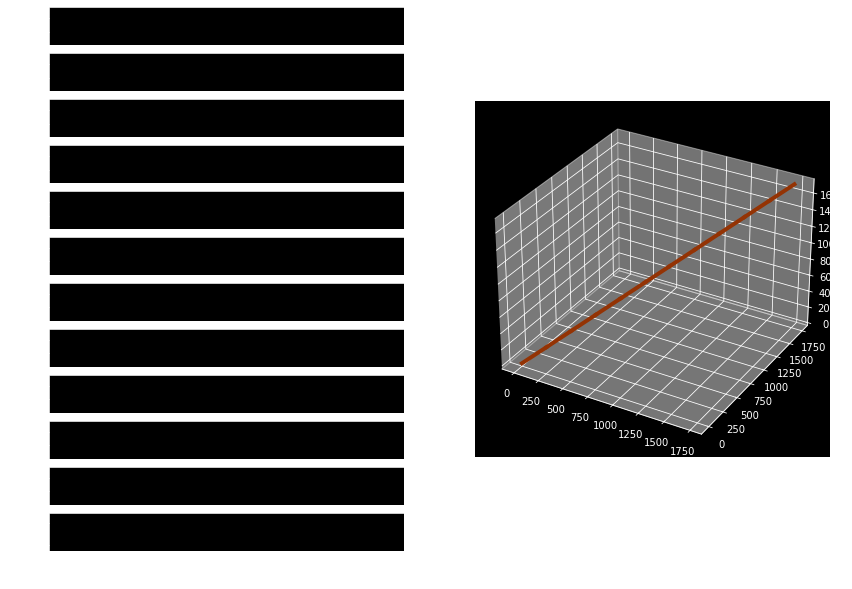

In [16]:
fig = plt.figure(figsize=(14,10))

# Plot voltage trace for each segment
lines = []
for i in range(1,cell.nseg+1):
    plt.subplot(cell.nseg+1,2,2*(cell.nseg+1-i)-1)
    line, = plt.plot([], [], lw=2)
    lines.append(line)
    plt.ylim([-80,60])
    plt.xlim([0,h.tstop])
    plt.yticks(np.arange(-80,60,50))
    plt.ylabel('v (mV)', fontweight='bold')
    plt.xticks(np.arange(0,h.tstop,5))
    plt.setp(plt.gca().get_xticklabels(), visible=False)

# Plot injected current in bottom trace
plt.subplot(cell.nseg+1,2,2*cell.nseg+1)
line, = plt.plot([], [], '-r', lw=2)
lines.append(line)
plt.xlim([0,h.tstop])
plt.ylim([-0.05,0.3])
plt.yticks([0, 0.2])
plt.xlabel('t (ms)', fontweight='bold')
plt.ylabel('i (nA)', fontweight='bold')

# Plot shapeplot
shapeax = plt.subplot(1,2,2, projection='3d')
shapelines = shapeplot(h,shapeax,lw=4)

# convert 't' and 'i' to lists
t = t.to_python()
I = I.to_python()

# Animate function -- reveal traces, and animate shape plot
def animate(i):
    # Animate the shape plot
    shape_animate(i)
    
    # Add additional animations
    i_t = int((i/nframes)*v.shape[0])
    for s in range(v.shape[1]):
        lines[s].set_data(t[0:i_t], v[0:i_t,s])  # voltage traces
    lines[-1].set_data(t[0:i_t], I[0:i_t])       # current trace
    return []
# Make animation
nframes = 100
shape_animate = shapeplot_animate(v,shapelines,nframes)
animation.FuncAnimation(fig, animate, frames=nframes, interval=40, blit=True)

### Similar example in more complex morphology

	1 


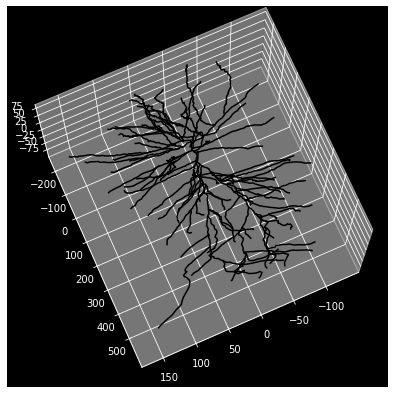

In [17]:
%reset -f
from __future__ import division
from neuron import h
import numpy as np
import pylab as plt
from PyNeuronToolbox.morphology import shapeplot
from mpl_toolkits.mplot3d import Axes3D

# Load morphology from file
h('xopen("geo5038804.hoc")')

# Plot shapeplot
plt.figure(figsize=(7,7))
shapeax = plt.subplot(111, projection='3d')
shapeax.view_init(75,66)
shapeplot(h,shapeax)
plt.show()

### Run simulation

In [18]:
from PyNeuronToolbox.record import ez_record, ez_convert

h.load_file('stdrun.hoc')

seclist = list(h.allsec())

for sec in seclist:
    sec.insert('hh')
    sec.Ra = 200.0

# Specify current injection
stim_sec = seclist[0]
stim_loc = 0.0
stim = h.IClamp(stim_loc,sec=stim_sec)
stim.delay = 0  # ms
stim.dur = 1    # ms
stim.amp = 20   # nA

# Use toolbox to record v
# ez_record records v in all compartments by default
(v,labels) = ez_record(h)

# Manually record time and current
t, I = h.Vector(), h.Vector()
t.record(h._ref_t)
I.record(stim._ref_i)

# Run the simulation 
h.init()
h.tstop = 10
h.run()

# Use toolbox convert v into a numpy 2D array
v = ez_convert(v) 

### 3D animation showing spread of action potential

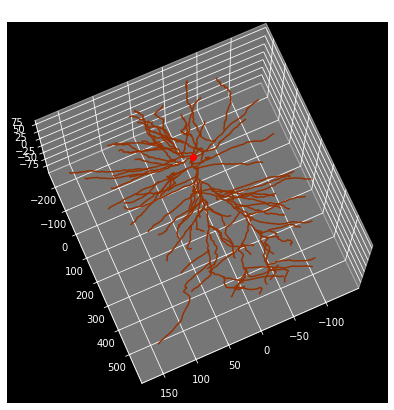

In [19]:
# Animation imports
from matplotlib import animation

# PyNeuronToolbox imports
from PyNeuronToolbox.morphology import shapeplot_animate, mark_locations

# Plot shapeplot (as above)
fig = plt.figure(figsize=(7,7))
shapeax = plt.subplot(111, projection='3d')
shapeax.view_init(75,66)
shapelines = shapeplot(h,shapeax)
plt.title('Current Injected at Red Dot',fontweight='bold')

# Now mark the location of our stimulation
mark_locations(h,stim_sec,stim_loc)

# Make the animation
nframes = 100
shape_animate = shapeplot_animate(v,shapelines,nframes)
animation.FuncAnimation(fig, shape_animate, frames=nframes, interval=40, blit=True)